In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (9, 6)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [2]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

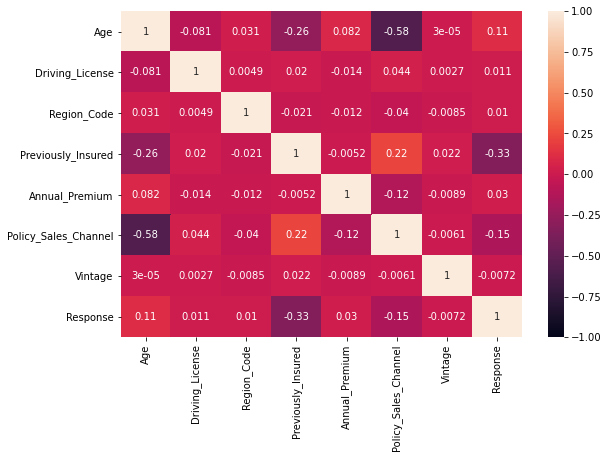

In [3]:
### Your code is here
cat_cols = data.select_dtypes('object').columns.to_list()

sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1);

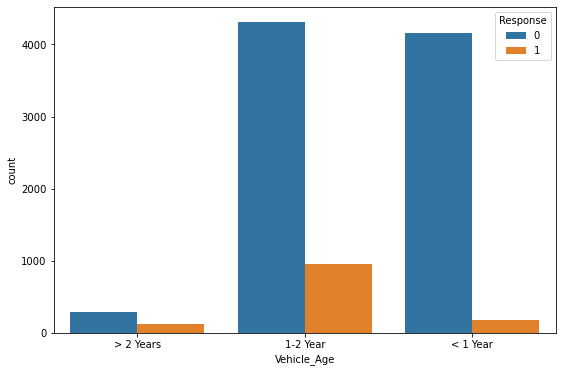

In [4]:
sns.countplot(data=data, x='Vehicle_Age', hue='Response');

In [5]:
data = pd.get_dummies(data, drop_first=True)

**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, RocCurveDisplay

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

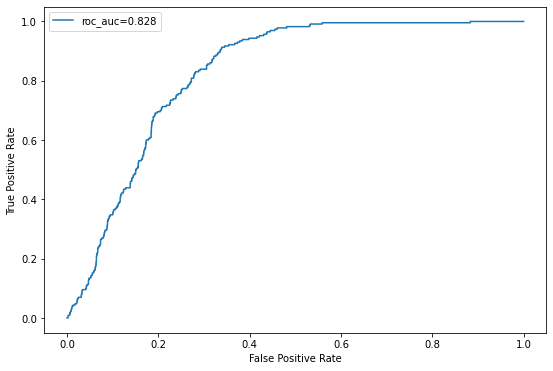

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

### Your code is here
grad_est = GradientBoostingClassifier(learning_rate = 1, random_state = 1, n_estimators = 100)
grad_est.fit(X_train, y_train)

fpr, tpr, _ = roc_curve(y_test, grad_est.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label=f'roc_auc={round(auc(fpr, tpr), 3)}')
plt.legend()
plt.show();


In [8]:
print(classification_report(y_test, grad_est.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.904     0.931     0.917      1770
           1      0.311     0.239     0.270       230

    accuracy                          0.852      2000
   macro avg      0.607     0.585     0.594      2000
weighted avg      0.836     0.852     0.843      2000



**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [9]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [10]:
### Your code is here
f1_matrix = np.zeros((8, 3))

for i, n_estimators in enumerate(n_estimators_list):
    for j, learning_rate in enumerate(learning_rate_list):
        g_est = GradientBoostingClassifier(learning_rate=learning_rate, random_state=1, n_estimators=n_estimators, max_depth=5)
        g_est.fit(X_train, y_train)
        f1_matrix[i, j] = f1_score(y_test, g_est.predict(X_test), average='weighted')


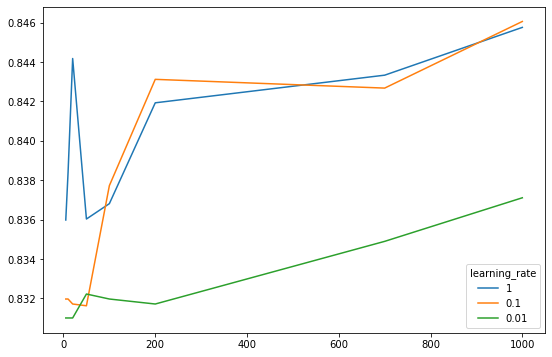

In [11]:
for j in range(3):
    plt.plot(n_estimators_list, f1_matrix[:, j], label=learning_rate_list[j])
    plt.legend(title='learning_rate')


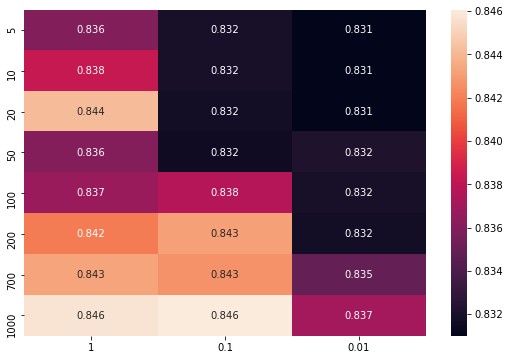

In [12]:
sns.heatmap(f1_matrix, annot=True, yticklabels=n_estimators_list, xticklabels=learning_rate_list, fmt='.3f');


**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [13]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

est_dict = {
    'rand_5': RandomForestClassifier(random_state=1, max_depth=5),
    'rand_5k': RandomForestClassifier(random_state=1, max_depth=5000),
    'gb_5': GradientBoostingClassifier(random_state=1, max_depth=5),
    'gb_5k': GradientBoostingClassifier(random_state=1, max_depth=5000),
}
f1_matrix_train = np.zeros((len(n_estimators_list), 4))
f1_matrix_test = np.zeros((len(n_estimators_list), 4))

### Your code is here
for i, n_est in enumerate(n_estimators_list):
    for j, est in enumerate(est_dict.values()):
        est.set_params(n_estimators=n_est)
        est.fit(X_train, y_train)
        f1_matrix_train[i, j] = f1_score(
            y_train, est.predict(X_train), average='weighted')
        f1_matrix_test[i, j] = f1_score(
            y_test, est.predict(X_test), average='weighted')

        


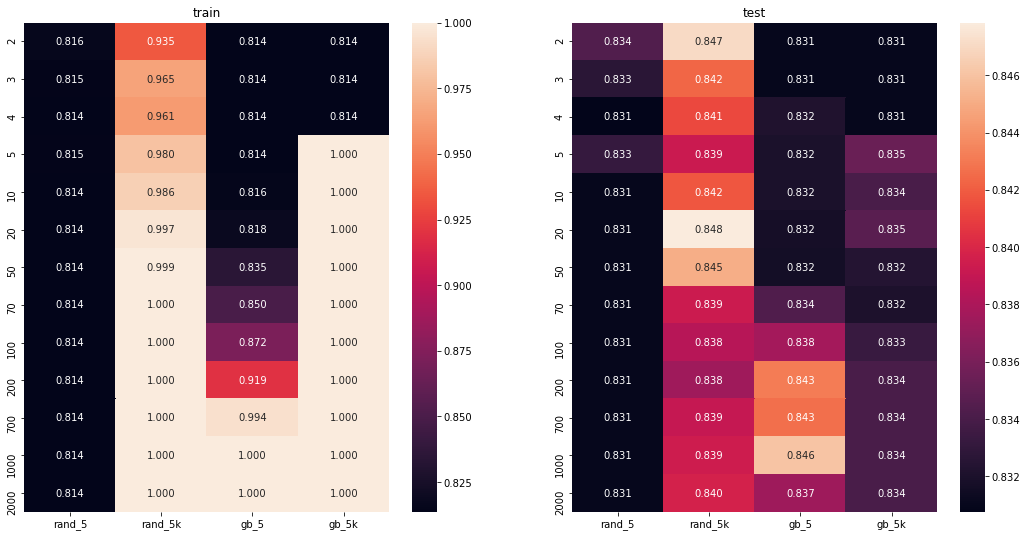

In [14]:
fig = plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
sns.heatmap(f1_matrix_train, annot=True, yticklabels=n_estimators_list,
            xticklabels=est_dict.keys(), fmt='.3f')
plt.title('train')

plt.subplot(1, 2, 2)
sns.heatmap(f1_matrix_test, annot=True, yticklabels=n_estimators_list,
            xticklabels=est_dict.keys(), fmt='.3f')
plt.title('test')

plt.show();

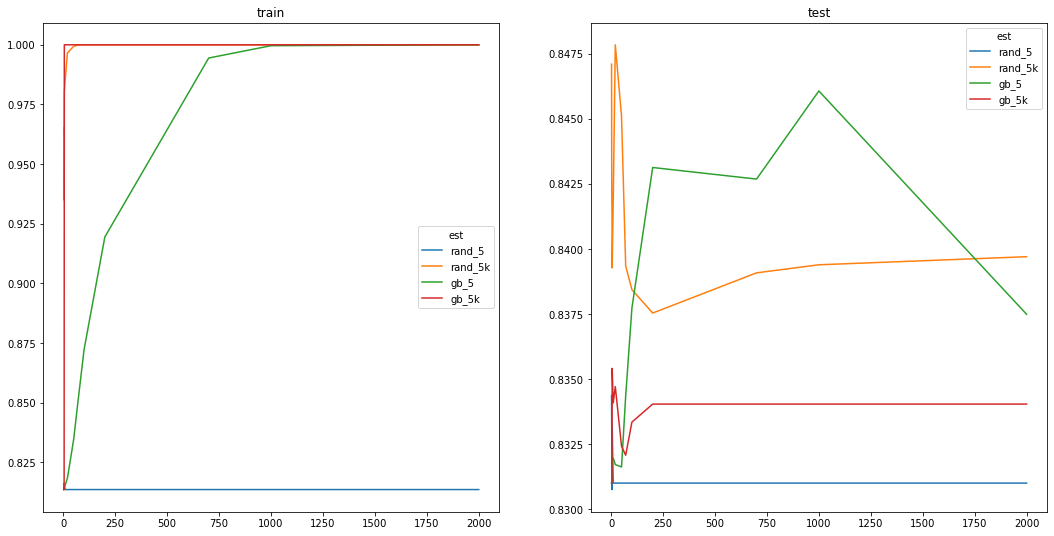

In [15]:
fig = plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
for j, key in enumerate(est_dict.keys()):
    plt.plot(n_estimators_list, f1_matrix_train[:, j], label=key)
    plt.legend(title='est')
plt.title('train')

plt.subplot(1, 2, 2)
for j, key in enumerate(est_dict.keys()):
    plt.plot(n_estimators_list, f1_matrix_test[:, j], label=key)
    plt.legend(title='est')
plt.title('test')

plt.show();

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [16]:
from catboost import CatBoostClassifier

### Your code is here
data_cat = pd.read_csv('vehicle_insurance.csv')

X_cat = data_cat.drop('Response', axis=1)
y_cat = data_cat['Response']

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_cat, y_cat,
                                                    random_state=1,
                                                    shuffle=True,
                                                    test_size=0.2)

cb_est = CatBoostClassifier(random_state=1)
cb_est.fit(X_c_train, y_c_train, cat_features=cat_cols, verbose=0)

In [17]:
f1_score(y_c_test, cb_est.predict(X_c_test), average='weighted')

0.8320549101380201

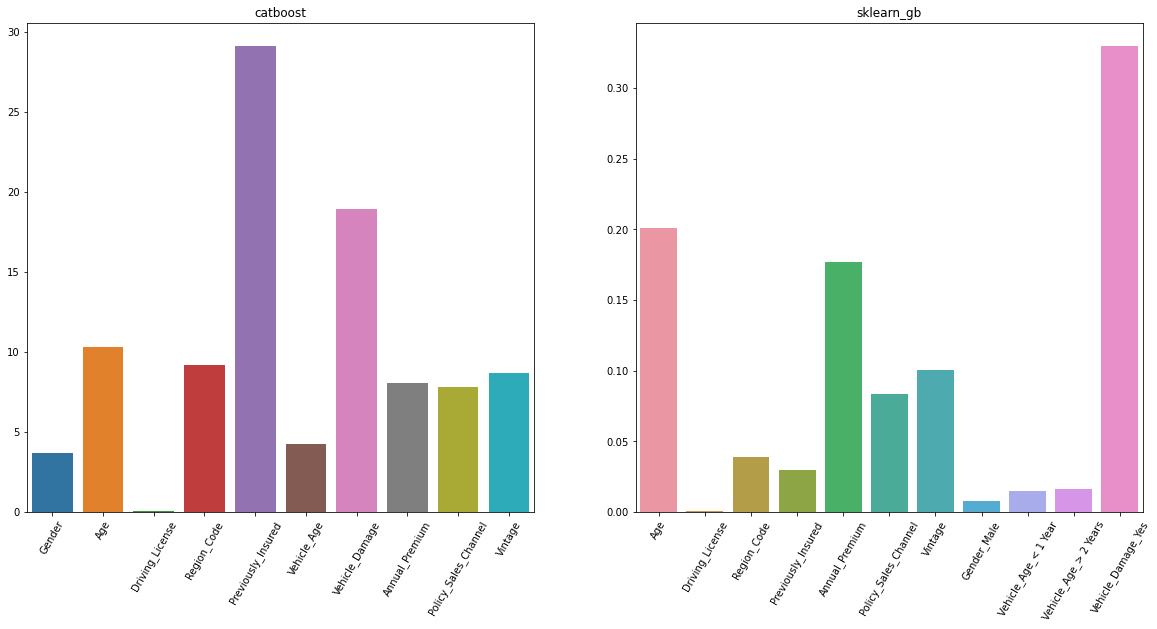

In [18]:
fig=plt.figure(figsize=(20, 9))

plt.subplot(1, 2, 1)
sns.barplot(x=X_cat.columns, y=cb_est.feature_importances_)
plt.title('catboost')
plt.xticks(rotation=60)

plt.subplot(1, 2, 2)
sns.barplot(x=X.columns, y=grad_est.feature_importances_)
plt.title('sklearn_gb')
plt.xticks(rotation=60)
plt.show();


**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

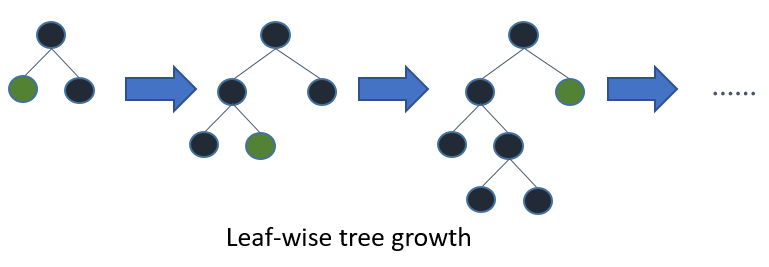

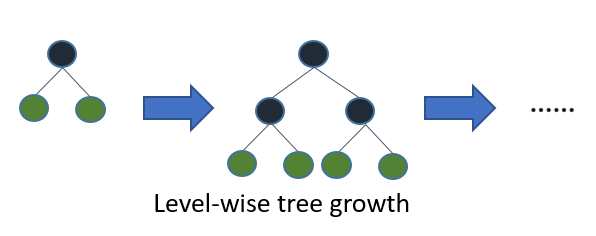

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

### Your code is here
custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]
lgbm_est = LGBMClassifier(random_state=1)

search = GridSearchCV(lgbm_est, param_grid=params, cv=custom_cv)
search.fit(X, y)

GridSearchCV(cv=[([7389, 9275, 2995, 5316, 356, 49, 7931, 1523, 7552, 496, 5110,
                   1957, 229, 1738, 7789, 7567, 4787, 2607, 3784, 8879, 1003,
                   5676, 4853, 8946, 9038, 3042, 8277, 5979, 2075, 4482, ...],
                  [9394, 898, 2398, 5906, 2343, 8225, 5506, 6451, 2670, 3497,
                   1087, 1819, 2308, 6084, 3724, 3184, 6387, 3728, 2702, 7883,
                   2930, 5988, 4890, 6718, 5423, 3213, 3017, 382, 4237, 4721, ...])],
             estimator=LGBMClassifier(random_state=1),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 5, 100],
                         'n_estimators': [100, 500, 1000, 2000]})

In [22]:
print(classification_report(y_test, search.predict(X_test), digits=2))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1770
           1       0.00      0.00      0.00       230

    accuracy                           0.89      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.78      0.89      0.83      2000

